# Outline

### Prepare Notebook
Import Python packages needed in this code

### Gather Data
1) Gather Real Data

### Define Functions for MMM Coefficient Retrieval Experiments

Steps 2-6 define functions that will be used in the loop in Step 7.  At the end of each cell block in Steps 2-6 I show a sample output of the function to make the code more understandable.

2) Create Synthetic Coefficients
3) Create Synthetic Dependent Variable
4) Add Noise
5) Retrieve Synthetic Coefficients with Regression
6) Add Data for Analysis

### Conduct MMM Coefficient Retrieval Experiments
7) Loop Steps 2-6

### Analyze Results (2 Examples)
8) Analyze the relationship between retrieved coefficient accuracy and other factors. <br>

    Example 1: Examine effect of independent variable contribution on coefficient accuracy. <br>
    Example 2: Examine the relationship between VIF and coefficient accuracy.


# Prepare Notebook

In [1]:
# Import Python packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Step 1: Gather Real Data

MMM Coefficient Retrieval Experiments should be conducted with real data for the independent variables.  In this step I collect and filter a publicly available MMM dataset from James Rawlins' GitHub repo.  Each row of the resulting dataframe represents a date while the values represent GRPs for each media type.  We also add a constant of 1 for the "base", which are the sales that would occur without advertising.

In [2]:
# Load the Excel file into a pandas DataFrame
df = pd.read_excel('https://github.com/jamesrawlins1000/Market-mix-modelling-data/raw/master/MMM_data.xlsx', engine = 'openpyxl')

# Select date subset
X = df[(df['DATE'] >= '2016-01-01') & (df['DATE'] <= '2016-12-31')]

# Select relevant fields
X = X[[
 'GRP (NewPaper ads)',
 'GRP(SMS)',
 'GRP(Radio',
 'GRP(Internet)',
 'GRP(TV)']]

# Clean up column names
X.columns = ['Newspaper','SMS','Radio','Internet','TV']

# Add base
X = X.assign(base=1.0)

# Display the DataFrame
X

,Newspaper,SMS,Radio,Internet,TV,base
2191,85.0218,20.9779,178.9666,381.9316,1466.8182,1.0
2192,42.8481,36.3533,131.8041,378.6272,1080.2727,1.0
2193,1430.8510,101.9914,106.3182,282.0000,901.0000,1.0
2194,996.8130,33.7128,92.0455,246.8182,962.8182,1.0
2195,390.3756,0.0000,891.5664,1540.4294,7307.3182,1.0
...,...,...,...,...,...,...
2552,87.6490,0.0000,105.0455,306.4545,754.2727,1.0
2553,38.2350,0.0000,108.0000,305.9545,776.6364,1.0
2554,92.4860,6.9945,112.9545,304.8636,867.1818,1.0
2555,206.9600,69.9877,115.3636,298.5455,905.4091,1.0


# Step 2: Create Synthetic Coefficients

In this step we randomly assign a coefficient to each media type.  These are the coefficients we will attempt to retrieve later!  We also assign a "base" coefficient.  Remember that the base is included in X as a constant of "1" to represent sales that would occur in the absence of media.  For the sake of simplicity, this base is assumed to be the same across each day and is effectively an intercept in the upcoming regression model in Step 5.

In [3]:
def create_synthetic_coefficients(X):
    
    base = 80000
    synthetic_coefficients = pd.DataFrame(
        index=X.columns,
        data={"Synthetic Coefficient": np.random.randint(low = 1, high = 100, size=len(X.columns))}
    )
    synthetic_coefficients.loc['base'] = base
    return synthetic_coefficients, base

# Example usage
Synthetic_Coefficients, base = create_synthetic_coefficients(X)
Synthetic_Coefficients

,Synthetic Coefficient
Newspaper,93
SMS,78
Radio,78
Internet,78
TV,90
base,80000


# Step 3: Create Synthetic Dependent Variable

In this step we multiply each synthetic coefficient by its corresponding independent variable in X.  We then add up the products to create the Synthetic Dependent Variable.

In [4]:
def calculate_dependent_variable(X, Synthetic_Coefficients, base):
    
    # Multiply independent variables by synthetic coefficients
    data_with_synthetic_dependent = X * Synthetic_Coefficients['Synthetic Coefficient']
    
    # Add products
    data_with_synthetic_dependent['Sales'] = data_with_synthetic_dependent.sum(axis=1) 
    
    return data_with_synthetic_dependent

# Example usage
Data_With_Synthetic_Dependent = calculate_dependent_variable(X, Synthetic_Coefficients, base)
Data_With_Synthetic_Dependent

,Newspaper,SMS,Radio,Internet,TV,base,Sales
2191,7907.0274,1636.2762,13959.3948,29790.6648,132013.638,80000.0,265307.0012
2192,3984.8733,2835.5574,10280.7198,29532.9216,97224.543,80000.0,223858.6151
2193,133069.1430,7955.3292,8292.8196,21996.0000,81090.000,80000.0,332403.2918
2194,92703.6090,2629.5984,7179.5490,19251.8196,86653.638,80000.0,288418.2140
2195,36304.9308,0.0000,69542.1792,120153.4932,657658.638,80000.0,963659.2412
...,...,...,...,...,...,...,...
2552,8151.3570,0.0000,8193.5490,23903.4510,67884.543,80000.0,188132.9000
2553,3555.8550,0.0000,8424.0000,23864.4510,69897.276,80000.0,185741.5820
2554,8601.1980,545.5710,8810.4510,23779.3608,78046.362,80000.0,199782.9428
2555,19247.2800,5459.0406,8998.3608,23286.5490,81486.819,80000.0,218478.0494


# Step 4: Add Noise

If we don't add some noise to the dependent variable, the regression will retrieve the synthetic variables without error.  (Try it if you don't believe me!)  So in this step we multiply the dependent variable by one plus a value drawn from a random Gaussian distribution. This also more accurately imitates real-life modeling situations.

In [5]:
def add_noise(Data_With_Synthetic_Dependent):
    
    Data_With_Synthetic_Dependent['Sales_with_Noise'] = Data_With_Synthetic_Dependent['Sales'] * (1 + np.random.normal(loc = 0, scale = .1, size = Data_With_Synthetic_Dependent.shape[0]))
    
    return Data_With_Synthetic_Dependent

# Example usage
Data_With_Synthetic_Dependent = add_noise(Data_With_Synthetic_Dependent)
Data_With_Synthetic_Dependent

,Newspaper,SMS,Radio,Internet,TV,base,Sales,Sales_with_Noise
2191,7907.0274,1636.2762,13959.3948,29790.6648,132013.638,80000.0,265307.0012,254360.045012
2192,3984.8733,2835.5574,10280.7198,29532.9216,97224.543,80000.0,223858.6151,253481.005654
2193,133069.1430,7955.3292,8292.8196,21996.0000,81090.000,80000.0,332403.2918,348530.473332
2194,92703.6090,2629.5984,7179.5490,19251.8196,86653.638,80000.0,288418.2140,310938.076424
2195,36304.9308,0.0000,69542.1792,120153.4932,657658.638,80000.0,963659.2412,743974.397088
...,...,...,...,...,...,...,...,...
2552,8151.3570,0.0000,8193.5490,23903.4510,67884.543,80000.0,188132.9000,195898.940837
2553,3555.8550,0.0000,8424.0000,23864.4510,69897.276,80000.0,185741.5820,188227.762447
2554,8601.1980,545.5710,8810.4510,23779.3608,78046.362,80000.0,199782.9428,218250.185616
2555,19247.2800,5459.0406,8998.3608,23286.5490,81486.819,80000.0,218478.0494,248211.989768


# Step 5: Retrieve Synthetic Coefficients with Regression

In this step we use regression to see how effectively we can retrieve the synthetic coefficients set in Step 2. Note that there are varying degrees of error.  Given the simplicity of the model, it is possible that some errors will be so substantial that a coefficient will be negative.  This can be a bit problematic for analysis, but we will address this issue later.

In [6]:
def retrieve_coefficients(X, Data_With_Synthetic_Dependent):
    
    # Set y
    y = Data_With_Synthetic_Dependent['Sales_with_Noise']

    # Create a linear regression model
    model = LinearRegression(fit_intercept = False)

    # Fit the model to the data
    model.fit(X, y)
    
    # Coefficients
    retrieved_coefficients = pd.DataFrame(index = X.columns, data = {'Retrieved Coefficient': model.coef_})
    retrieved_coefficients = retrieved_coefficients.merge(Synthetic_Coefficients, how = 'left', left_index = True, right_index = True)
    retrieved_coefficients['Error'] = np.maximum(retrieved_coefficients['Retrieved Coefficient'], retrieved_coefficients['Synthetic Coefficient']) / np.minimum(retrieved_coefficients['Retrieved Coefficient'], retrieved_coefficients['Synthetic Coefficient']) -1
    return retrieved_coefficients


# Example usage
retrieved_coefficients = retrieve_coefficients(X, Data_With_Synthetic_Dependent)
retrieved_coefficients


,Retrieved Coefficient,Synthetic Coefficient,Error
Newspaper,96.103445,93,0.033370
SMS,137.408492,78,0.761647
Radio,54.401212,78,0.433792
Internet,35.798702,78,1.178850
TV,90.918799,90,0.010209
base,92492.944463,80000,0.156162


# Step 6: Add Data for Analysis

This step contains three blocks of code to assist with the two analyses conducted in Step 8.  

The first block defines a function that indicates each independent variable's contribution to the dependent variable.  So, for example, of all the sales, what percent of sales should be attributed to TV?

The second block of code calculates the VIF (variance inflation factor, a measure of multicollinearity) for each independent variable.  

The third block of code creates the Analysis_Data dataframe and appends the contribution and VIF data.

In [7]:
def find_percent_contribution(Data_With_Synthetic_Dependent):
    contribution_sum = Data_With_Synthetic_Dependent.sum()
    percent_contribution = contribution_sum / contribution_sum['Sales']
    attribution = pd.DataFrame({
        'Percent_Contribution': percent_contribution
    })
    

    return attribution

# Example usage
Attribution = find_percent_contribution(Data_With_Synthetic_Dependent)
Attribution

,Percent_Contribution
Newspaper,0.170461
SMS,0.008837
Radio,0.041388
Internet,0.086390
TV,0.390252
base,0.302672
Sales,1.000000
Sales_with_Noise,1.004406


In [8]:
def vif(X):
    
    vif_data = pd.DataFrame()
    vif_data.index = [i for i in X.columns[0:X.shape[1]-1]]
    vif_data["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1]-1)]
    
    return vif_data

# Example usage
vif_data = vif(X)
vif_data


,VIF
Newspaper,1.134640
SMS,1.070594
Radio,1.731384
Internet,2.451906
TV,2.721770


In [9]:
def analysis_data(retrieved_coefficients, Attribution, vif_data):
    
    Analysis_Data = retrieved_coefficients.merge(Attribution, how = 'left', left_index = True, right_index = True)
    Analysis_Data = Analysis_Data.merge(vif_data, how = 'left', left_index = True, right_index = True)
    
    return Analysis_Data

Analysis_Data = analysis_data(retrieved_coefficients, Attribution, vif_data)
Analysis_Data

,Retrieved Coefficient,Synthetic Coefficient,Error,Percent_Contribution,VIF
Newspaper,96.103445,93,0.033370,0.170461,1.134640
SMS,137.408492,78,0.761647,0.008837,1.070594
Radio,54.401212,78,0.433792,0.041388,1.731384
Internet,35.798702,78,1.178850,0.086390,2.451906
TV,90.918799,90,0.010209,0.390252,2.721770
base,92492.944463,80000,0.156162,0.302672,NaN


# Step 7: Loop Steps 2-6

In this step we perform repeat Steps 2-6 numerous times in order to gather enough data points to get an accurate distribution of results.

In [10]:
Aggregated_Results = pd.DataFrame()

for i in range(100):
    Synthetic_Coefficients, base = create_synthetic_coefficients(X)
    Data_With_Synthetic_Dependent = calculate_dependent_variable(X, Synthetic_Coefficients, base)
    Data_With_Synthetic_Dependent = add_noise(Data_With_Synthetic_Dependent)
    Retrieved_Coefficients = retrieve_coefficients(X, Data_With_Synthetic_Dependent)
    Attribution = find_percent_contribution(Data_With_Synthetic_Dependent)
    VIF_Data = vif(X)
    Analysis_Data = analysis_data(Retrieved_Coefficients, Attribution, VIF_Data)
    
    Aggregated_Results = pd.concat([Aggregated_Results, Analysis_Data], axis = 0)

Aggregated_Results


,Retrieved Coefficient,Synthetic Coefficient,Error,Percent_Contribution,VIF
Newspaper,27.754814,30,0.080894,0.078288,1.134640
SMS,77.648447,67,0.158932,0.010807,1.070594
Radio,30.288089,28,0.081717,0.021153,1.731384
Internet,-3.349463,13,-4.881219,0.020500,2.451906
TV,75.158756,71,0.058574,0.438323,2.721770
...,...,...,...,...,...
SMS,38.549270,94,1.438438,0.016560,1.070594
Radio,61.348711,65,0.059517,0.053634,1.731384
Internet,71.013325,64,0.109583,0.110229,2.451906
TV,23.174848,23,0.007602,0.155087,2.721770


# Step 8: Analyze Results

In Step 8 we look at the relationship between retrieved coefficient error and other factors.

## Example 1: Correlate Size of Contribution to Sales and Coefficient Accuracy

In this section, we investigate whether channels that create more sales have more accurate retrieved coefficients.  The scatter plot below shows that there is strong evidence that larger channels have more accurate retrieved coefficients.  This indicates that we should have greater trust in the MMM results for large channels than for small channels.  Additionally, it provides a strong argument for calibrating MMMs with experiment results for smaller channels.

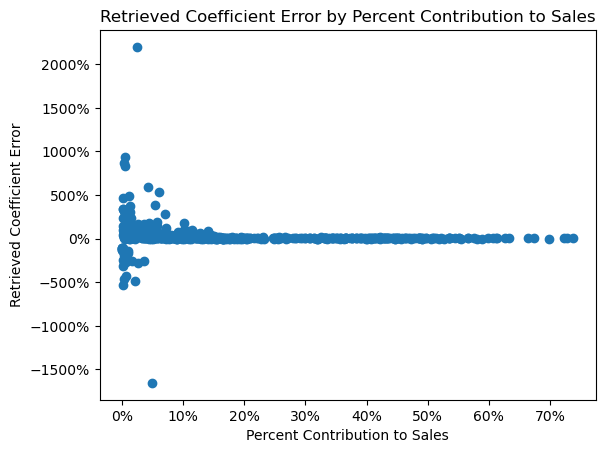

In [11]:
# Plot data
plt.scatter(data=Aggregated_Results, x='Percent_Contribution', y='Error')

# Set title and axis labels
plt.title('Retrieved Coefficient Error by Percent Contribution to Sales')
plt.xlabel('Percent Contribution to Sales')
plt.ylabel('Retrieved Coefficient Error')

# Set the x-axis and y-axis tick labels to percentage format
plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=1))
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1))

# Show plot
plt.show()

This next block of code produces a bar graph showing mean errors by percent contribution to sales.  It is simply a different way to visualize the data in the scatter plot above.  To avoid the problem of negative errors canceling out all positive errors, all negative errors are replaced with a value of 100%.  

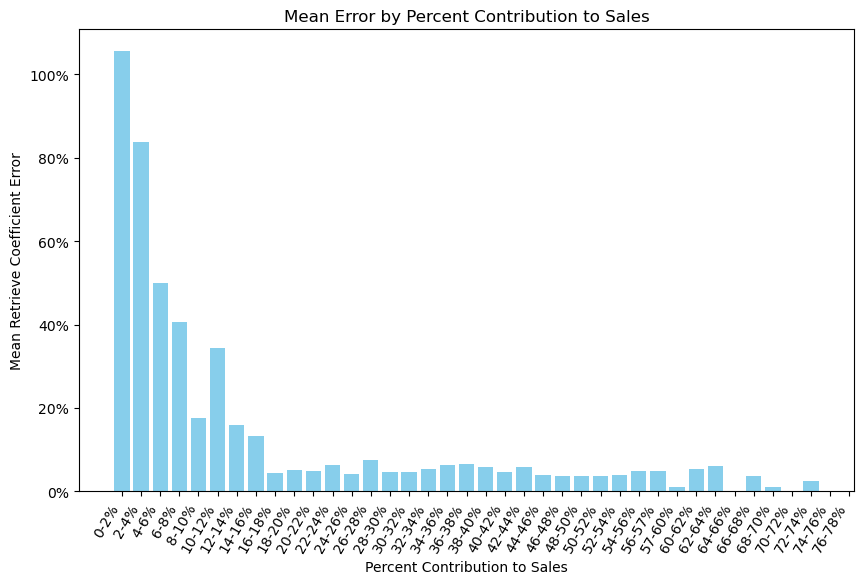

In [12]:
# Copy Aggregated_Results dataframe
Aggregated_Results_Copy = Aggregated_Results.copy()

# Change all negative errors to positive 100%
Aggregated_Results_Copy['Error'] = np.where(Aggregated_Results_Copy['Error'] < 0, 1, Aggregated_Results_Copy['Error'])

# Define the bins
bins = np.linspace(0, 1, 51)  # 50 equal bins between 0 and 1

# Generate labels in the format '2-4%'
labels = [f'{int(bins[i]*100)}-{int(bins[i+1]*100)}%' for i in range(len(bins)-1)]

# Bin the data based on 'Percent_Contribution'
Aggregated_Results_Copy['binned'] = pd.cut(Aggregated_Results_Copy['Percent_Contribution'], bins=bins, labels=labels, include_lowest=True)

# Calculate the mean 'Error' for each bin
binned_errors = Aggregated_Results_Copy.groupby('binned', observed = False)['Error'].mean()

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.bar(binned_errors.index.astype(str), binned_errors.values, color='skyblue')

# Add labels and title
plt.xlabel('Percent Contribution to Sales')
plt.ylabel('Mean Retrieve Coefficient Error')
plt.title('Mean Error by Percent Contribution to Sales')

# Set the y-axis tick labels to percentage format
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1))

# Set x-tick labels to the format '2-4%'
plt.xticks(rotation=60, ha='right')

# Show the plot
plt.show()

## Example 2: Correlate VIF and Retrieved Coefficient Accuracy

Because VIF values are dependent only on the independent variables, the VIF values will be the same for any channel across iterations in the loop.  In the first cell below, we look at summary statistics.  In the second cell, we look at a scatter plot that shows distributions.  We can see that in the relatively narrow range of VIF values that we have, VIF values are not especially related to retrieved coefficient error.  Given VIF values in this narrow range, we might decide not to use them as a proxy for coefficient accuracy in MMM models.

In [13]:
VIF_Pivot = pd.pivot_table(Aggregated_Results, index = 'VIF', aggfunc={'Error': ['mean', 'median']})
VIF_Pivot

Error          
              mean    median
VIF                         
1.070594  0.423750  0.408170
1.134640  0.085418  0.034388
1.731384  0.545846  0.216849
2.451906  0.425845  0.288511
2.721770  0.115102  0.059208

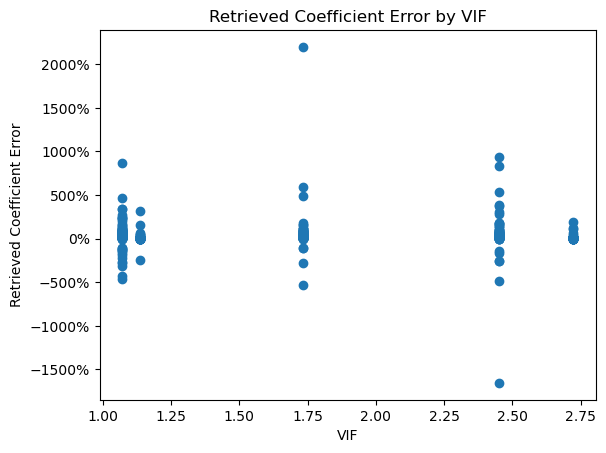

In [14]:
# Plot data
plt.scatter(data = Aggregated_Results, x = 'VIF', y = 'Error')

# Set title and axis labels
plt.title('Retrieved Coefficient Error by VIF')
plt.xlabel('VIF')
plt.ylabel('Retrieved Coefficient Error')

# Set the x-axis and y-axis tick labels to percentage format
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1))
